# Machine Learning Engineer Nanodegree

## Capstone Project

### Using Computer Vision for Facial Expression Classification

This project seeks to investigate the use of computer vision techniques to build a classifier that can classify different faces, based on facial expressions.

A deep learning approach will be taken to this problem, investigating the use of convolutional neural networks (CNNs). 

A simple benchmark CNN will first be investigated, followed by a more complex and deep network.

In addition, the use of pre-existing architectures for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/) will be explored to aid performance in the facial expression classification problem. 






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint  

from keras import losses
from keras import backend as K
from keras import applications
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


### Reading the Data

The dataset can be obtained from [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge). For the purpose of this notebook, and determining the best classification model, only the first 15,000 entries will be used. Later, the entire dataset will be used for training, testing and validation on the optimal model, to gain an idea for the true performance of the model.

Below, Pandas is used to read the input data into a Data Frame

In [2]:
use_section_data = False
smaller_section_data = False

if use_section_data:
    data = pd.read_csv("section_fer2013.csv")    
    if smaller_section_data:
        data = pd.read_csv("smaller_section_fer2013.csv")
else:
    data = pd.read_csv("fer2013cp.csv")

labels = data['emotion']

features = data.drop(['emotion','Usage'], axis=1, inplace=False)


### Pre-Processing the Data

The raw data is in .csv format, with every pixel value listed in a single cell, for each image, separated by spaces.

Below, each pixel value is separated, to be an individual value in a Python list, within a Data Frame.

In addition, the data will be converted to a tensor format.

In [3]:
temp_list = []

for i in features['pixels']:
    temp_list.append(i.split())
    
features.drop('pixels',axis=1,inplace=True)

features['pixels'] = pd.Series(temp_list)

Of all of the data that has been imported, 20% will be used for training, 10% for validation, and 70% for training.

In [4]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state=0)

In [5]:
def df_to_tensor(X_in, im_dim, reshape=True, triple_channels=False, horizontal_flip_double=False):
    
    # convert from the dataframe which contains Python lists with all pixel values, into a tensor, suitable for
    # input into a convolutional neural network
    
    list_of_2d_arrays = []
    
    
    
    for image in X_in['pixels']:
        pixel_array = []
        
        for pixel in image:
            if not triple_channels:
                pixel_array.append(int(pixel))
            else:
                pixel_array.append([int(pixel),int(pixel),int(pixel)])
        
        pixel_array = [pixel_array[x:x+im_dim] for x in range(0,len(pixel_array),im_dim)]
        
        
        
        list_of_2d_arrays.append(pixel_array)
        
    if horizontal_flip_double == True:
        
        reversed_array = []
        
        for pixel_row in pixel_array:
            reversed_array.append(pixel_row[::-1])
            
        list_of_2d_arrays.append(reversed_array)
            
            
        
        
    np_arr =  np.array(list_of_2d_arrays)
    
    if reshape:
        return np_arr.reshape(np_arr.shape[0], 48, 48, 1)
    else:
        return np_arr

### Sample Visualization

A few of the images from the dataset will be plotted below.

In [6]:
# take a few sample images to provide a visualization

samples = df_to_tensor(features,48)

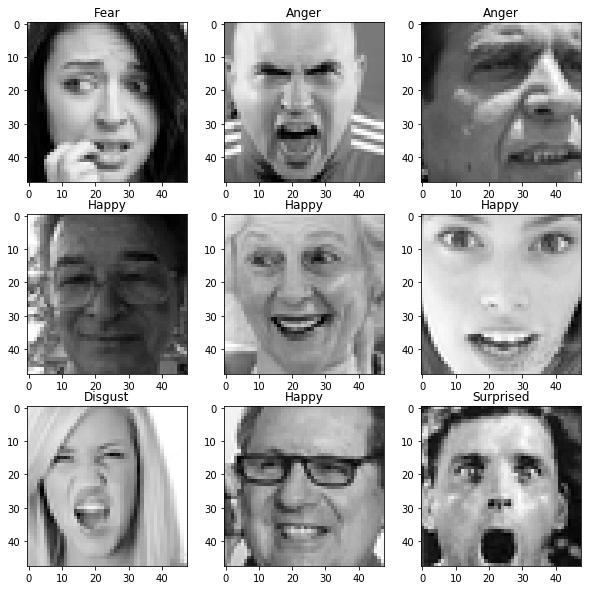

In [7]:
seed_number = 21

two_d_array = samples[seed_number].reshape(48,48)

fig = plt.figure(figsize=(10, 10))

num_rows = 3

num_columns = 3

hardcoded_labels = ["Fear", "Anger", "Anger", "Happy", "Happy",
                   "Happy", "Disgust", "Happy", "Surprised"]

for i in range(num_rows*num_columns):
    ax = fig.add_subplot(num_rows,num_columns,i + 1)
    ax.imshow(samples[seed_number + i].reshape(48,48), cmap='gray')
    ax.title.set_text(hardcoded_labels[i])



### Frequency of Expressions

The distribution of how many times each expression appears in the dataset is important to inform what metrics are suitable for assessing the classifier. Below a bar graph showing the relative frequencies of each expression is shown.

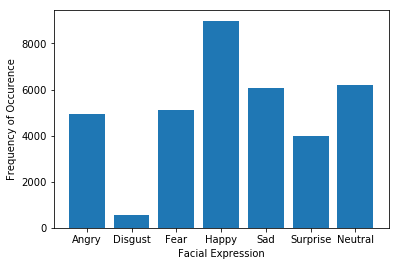

In [8]:
# seeing the distribution of each emotion in the dataset

frequency_list = np.zeros(7)

for label in labels:
    frequency_list[int(label)] += 1
    
emotion_indices = range(1,8)

x_axis_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise',
         'Neutral']


bar = plt.bar(emotion_indices, frequency_list, align='center')

plt.xticks(emotion_indices, x_axis_labels )

plt.xlabel("Facial Expression")

plt.ylabel("Frequency of Occurence")



plt.show()

In [9]:
train_tensors = df_to_tensor(X_train,48).astype('float32')/255
valid_tensors = df_to_tensor(X_val,48).astype('float32')/255
test_tensors = df_to_tensor(X_test,48).astype('float32')/255

train_targets = np.array(pd.get_dummies(y_train))
valid_targets = np.array(pd.get_dummies(y_val))
test_targets = np.array(pd.get_dummies(y_test))


In [10]:
img_width = 48
img_height = 48

### Evaluation Metrics

Due to the uneven distribution of facial expressions in the dataset, illustrated above, accuracy alone is not a suitable measure of classifier performance. Instead <b>categorical cross entropy loss</b> will be used to rank classifiers.


In [11]:
import numpy as np


def my_categorical_cross_entropy(predictions_vector, targets_vector, epsilon_ = 0.0001):
    #calculates, for each individual sample, the contribution to the total categorical cross entropy of the predictions with respect to the targets

    for i in range(len(predictions_vector)):
        if predictions_vector[i] <= 0:
            predictions_vector[i] = epsilon_
    
    predictions = np.array(predictions_vector)

    targets = np.array(targets_vector)

    log_vector = -np.log(predictions_vector)

    return targets.dot(log_vector)


In [12]:
def manual_total_cce(predictions, targets ):
    
    # predictions and targets inputs must be numpy arrays with the shape: (number of samples, number of classes)
    
    total = 0
    
    for i in range(predictions.shape[0]):
        if predictions.shape[0] != targets.shape[0]:
            print("WRONG INPUT DIMS!")
            return None
        total += my_categorical_cross_entropy(predictions[i], targets[i])
    
    return float(total)/predictions.shape[0]

In [13]:
# function for getting model predictions of a CNN

def get_model_predictions(input_model, input_test_tensors):
    # closely based on code provided in the Dog Breeds Classifier project
    return [input_model.predict(np.expand_dims(tensor, axis=0)) for tensor in input_test_tensors]

In [14]:
def get_model_accuracy(input_model, input_test_tensors, input_test_targets):
    # closely based on code provided in the Dog Breeds Classifier project
    # get index of predicted facial expression for test set images
    expression_predictions = [np.argmax(input_model.predict(np.expand_dims(tensor, axis=0))) for tensor in input_test_tensors]

    test_accuracy = 100*np.sum(np.array(expression_predictions)==np.argmax(input_test_targets, axis=1))/len(expression_predictions)
    
    return test_accuracy
    

### Baseline Model

First, a simple CNN will be used to build a classifier, to which others can be compared. The baseline comprises only of one convolutional layer with 16 features and is expected to pick up basic features in the faces that will give it some degree of accuracy with the classification task


In [15]:
model_baseline = Sequential()
model_baseline.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(48,48,1)))
model_baseline.add(MaxPooling2D(pool_size=2))
model_baseline.add(Flatten())
model_baseline.add(Dense(100, activation='relu'))
model_baseline.add(Dense(7, activation='softmax'))

model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 707       
Total params: 922,487.0
Trainable params: 922,487.0
Non-trainable params: 0.0
_________________________________________________________________


In [16]:
model_baseline.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.baseline.hdf5', 
                               verbose=1, save_best_only=True)

history = model_baseline.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 25120 samples, validate on 3589 samples
Epoch 1/20
25120/25120 [==============================] - 36s - loss: 1.6552 - acc: 0.3463 - val_loss: 1.5284 - val_acc: 0.4257
Epoch 2/20
25120/25120 [==============================] - 8s - loss: 1.4937 - acc: 0.4315 - val_loss: 1.4681 - val_acc: 0.4505
Epoch 3/20
25120/25120 [==============================] - 8s - loss: 1.4098 - acc: 0.4674 - val_loss: 1.4498 - val_acc: 0.4519
Epoch 4/20
25120/25120 [==============================] - 8s - loss: 1.3449 - acc: 0.4912 - val_loss: 1.4620 - val_acc: 0.4464
Epoch 5/20
25120/25120 [==============================] - 8s - loss: 1.2920 - acc: 0.5129 - val_loss: 1.4489 - val_acc: 0.4461
Epoch 6/20
25120/25120 [==============================] - 8s - loss: 1.2412 - acc: 0.5318 - val_loss: 1.4540 - val_acc: 0.4486
Epoch 7/20
25120/25120 [==============================] - 8s - loss: 1.2000 - acc: 0.5510 - val_loss: 1.5024 - val_acc: 0.4349
Epoch 8/20
25120/25120 [==============================] - 8s 

In [18]:
model_baseline.load_weights('saved_models/weights.best.baseline.hdf5')

In [19]:
print("Test accuracy: %.4f%% " % get_model_accuracy(model_baseline, test_tensors, test_targets))

Test accuracy: 45.4305% 


In [20]:
print(get_model_accuracy(model_baseline, test_tensors, test_targets))

45.4304820284


dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])


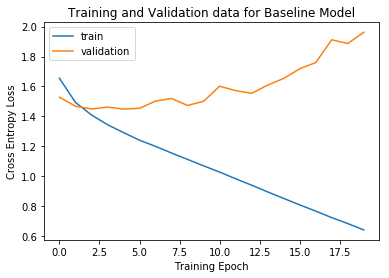

In [21]:
# CODE OBTAINED FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'validation'], loc='upper left')
plt.title('Training and Validation data for Baseline Model')
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [22]:
preds_ = get_model_predictions(model_baseline, test_tensors)

holder = np.array(preds_)

preds_np = np.array(preds_, dtype='float32').reshape(holder.shape[0],7)


[[  1.28602935e-02   7.11517700e-04   8.76329020e-02 ...,   2.02042144e-02
    1.49735317e-01   1.05642788e-01]
 [  2.27117240e-01   1.13362074e-02   1.24869853e-01 ...,   4.70569223e-01
    5.15299663e-02   8.10307786e-02]
 [  2.70138890e-01   2.25366466e-03   4.23930556e-01 ...,   2.56712418e-02
    1.22724168e-01   8.05180669e-02]
 ..., 
 [  2.91146547e-01   5.37341833e-03   1.34398058e-01 ...,   7.41966888e-02
    1.32459244e-02   3.03122252e-02]
 [  8.14870670e-02   2.65657989e-04   5.18936276e-01 ...,   1.84470534e-01
    5.36397360e-02   7.81363398e-02]
 [  8.49090442e-02   6.27537370e-02   6.28602803e-01 ...,   4.68120836e-02
    6.21526316e-02   8.05550069e-03]]
(7178, 7)


In [23]:
print(manual_total_cce(preds_np, test_targets))

1.4321339317629496


### Advanced Model

### Image Augmentation




In [15]:
from keras.preprocessing.image import ImageDataGenerator

def augment_data(train_tensors_input, valid_tensors_input, shift_width=0.1, shift_height=0.1, flip_hor=True,
                flip_vert=False):
    
    
    datagen_train = ImageDataGenerator(
        width_shift_range = shift_width,
        height_shift_range = shift_height,
        horizontal_flip = flip_hor,
        vertical_flip = flip_vert )

    # create and configure augmented image generator
    datagen_valid = ImageDataGenerator(
        width_shift_range = shift_width,
        height_shift_range = shift_height,
        horizontal_flip = flip_hor,
        vertical_flip = flip_vert )

    # fit augmented image generator on data
    datagen_train.fit(train_tensors_input)
    datagen_valid.fit(valid_tensors_input)
    
    return (datagen_train, datagen_valid)
    

In [16]:
(datagen_train, datagen_valid) = augment_data(train_tensors, valid_tensors)

In [17]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

In [18]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:

epochs = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_augmentation.hdf5', 
                               verbose=1, save_best_only=True)

#With image augmentation

batch_size = 20

history = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/50
1256/1256 [==============================] - 26s 21ms/step - loss: 1.7169 - acc: 0.3117 - val_loss: 1.6562 - val_acc: 0.3363
Epoch 2/50
1256/1256 [==============================] - 19s 15ms/step - loss: 1.5601 - acc: 0.3927 - val_loss: 1.5471 - val_acc: 0.3983
Epoch 3/50
1256/1256 [==============================] - 18s 15ms/step - loss: 1.4654 - acc: 0.4411 - val_loss: 1.4181 - val_acc: 0.4517
Epoch 4/50
1256/1256 [==============================] - 20s 16ms/step - loss: 1.4064 - acc: 0.4614 - val_loss: 1.4214 - val_acc: 0.4450
Epoch 5/50
1256/1256 [==============================] - 20s 16ms/step - loss: 1.3648 - acc: 0.4794 - val_loss: 1.3566 - val_acc: 0.4715
Epoch 6/50
1256/1256 [==============================] - 20s 16ms/step - loss: 1.3339 - acc: 0.4943 - val_loss: 1.3229 - val_acc: 0.4869
Epoch 7/50
1256/1256 [==============================] - 19s 15ms/step - loss: 1.3138 - acc: 0.5008 - val_loss: 1.3024 - val_acc: 0.4980
Epoch 8/50
1256/1256 [==========================

Epoch 30/50
1256/1256 [==============================] - 19s 15ms/step - loss: 1.2361 - acc: 0.5368 - val_loss: 1.2766 - val_acc: 0.5025
Epoch 31/50
1256/1256 [==============================] - 20s 16ms/step - loss: 1.2488 - acc: 0.5316 - val_loss: 1.2740 - val_acc: 0.5196
Epoch 32/50
1256/1256 [==============================] - 18s 15ms/step - loss: 1.2506 - acc: 0.5317 - val_loss: 1.2681 - val_acc: 0.5223
Epoch 33/50
1256/1256 [==============================] - 18s 15ms/step - loss: 1.2558 - acc: 0.5323 - val_loss: 1.3184 - val_acc: 0.5053
Epoch 34/50
1256/1256 [==============================] - 19s 15ms/step - loss: 1.2592 - acc: 0.5258 - val_loss: 1.2848 - val_acc: 0.5008
Epoch 35/50
1256/1256 [==============================] - 20s 16ms/step - loss: 1.2600 - acc: 0.5236 - val_loss: 1.3412 - val_acc: 0.4908
Epoch 36/50
1256/1256 [==============================] - 19s 15ms/step - loss: 1.2634 - acc: 0.5236 - val_loss: 1.2766 - val_acc: 0.5123
Epoch 37/50
1256/1256 [==================

In [20]:
model.load_weights('saved_models/weights.best.from_scratch_augmentation.hdf5')

In [21]:
# get index of predicted facial expression for test set images
print("Test accuracy: %.4f%% " % get_model_accuracy(model, test_tensors, test_targets))

Test accuracy: 54.9178% 


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


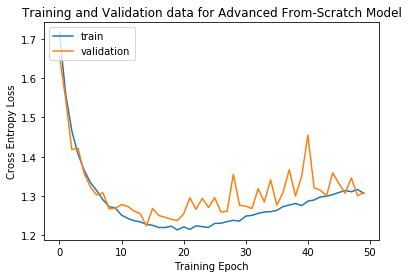

In [22]:
# CODE OBTAINED FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'validation'], loc='upper left')
plt.title('Training and Validation data for Advanced From-Scratch Model')
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [23]:
preds_ = get_model_predictions(model, test_tensors)

holder = np.array(preds_)

preds_np = np.array(preds_, dtype='float32').reshape(holder.shape[0],7)

[[  4.01534885e-03   8.40757930e-05   1.08661763e-02 ...,   1.10503696e-02
    2.91331783e-02   9.17059332e-02]
 [  7.14554936e-02   9.87932435e-05   3.55943471e-01 ...,   3.52179945e-01
    1.46288857e-01   4.16773744e-02]
 [  3.93585861e-02   3.46484399e-06   1.42116204e-01 ...,   4.05573612e-03
    7.69154072e-01   5.42464433e-03]
 ..., 
 [  2.58753985e-01   2.14125190e-04   3.94387156e-01 ...,   3.09118163e-02
    2.78224528e-01   3.27623426e-03]
 [  2.26812184e-01   6.85125764e-04   1.88626513e-01 ...,   1.82357877e-01
    4.02090922e-02   2.99365819e-01]
 [  8.11867177e-01   1.77207554e-03   1.38476476e-01 ...,   2.38973554e-03
    1.59930624e-02   1.41546770e-03]]
(7178, 7)


In [25]:
print(manual_total_cce(preds_np, test_targets))

1.1748033858498181


### Transfer Learning

It is suitable to explore the use of other CNNs that have been used for other computer vision applications. Below, the performance of the pre-trained networks Inception, VGG-19 and Resnet50 will be explored

In [52]:

X_train_transf, X_test_transf, X_val_transf = X_train, X_test, X_val

y_train_transf, y_test_transf, y_val_transf = y_train, y_test, y_val


sample = df_to_tensor(X_train_transf, 48, reshape=False)


In [53]:
# creating transfer tensors

train_tensors_transf = df_to_tensor(X_train_transf,48,reshape=False, triple_channels=True).astype('float32')/255
valid_tensors_transf = df_to_tensor(X_val_transf,48, reshape=False, triple_channels=True).astype('float32')/255
test_tensors_transf = df_to_tensor(X_test_transf,48, reshape=False, triple_channels=True).astype('float32')/255

train_targets_transf = np.array(pd.get_dummies(y_train_transf))
valid_targets_transf = np.array(pd.get_dummies(y_val_transf))
test_targets_transf = np.array(pd.get_dummies(y_test_transf))


In [54]:
# Note: the code below is an adaptation of a code snippet by Prakash Jay,
# obtained from: https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8

img_width, img_height = 48, 48
batch_size = 16
epochs = 50

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [55]:
# Image augmentation for transfer model

from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train_transf = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid_transf = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train_transf.fit(train_tensors_transf)
datagen_valid_transf.fit(valid_tensors_transf)

In [56]:
# change this code to freeze some of the layers of the VGG-19 model with the pre-trained weights
"""
for layer in model.layers:
    layer.trainable = False
"""


'\nfor layer in model.layers:\n    layer.trainable = False\n'

In [57]:
# duplicate of prakash jay code
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [58]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.transfer_example_six.hdf5', 
                               verbose=1, save_best_only=True)

history = model_final.fit_generator(datagen_train_transf.flow(train_tensors_transf, train_targets_transf, batch_size=batch_size),
                    steps_per_epoch=train_tensors_transf.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid_transf.flow(valid_tensors_transf, valid_targets_transf, batch_size=batch_size),
                    validation_steps=valid_tensors_transf.shape[0] // batch_size)

Epoch 1/50
1570/1570 [==============================] - 182s - loss: 1.8510 - acc: 0.2238 - val_loss: 1.7669 - val_acc: 0.2414
Epoch 2/50
1570/1570 [==============================] - 192s - loss: 1.7189 - acc: 0.2796 - val_loss: 1.7012 - val_acc: 0.3182
Epoch 3/50
1570/1570 [==============================] - 192s - loss: 1.6418 - acc: 0.3264 - val_loss: 1.6351 - val_acc: 0.3980
Epoch 4/50
1570/1570 [==============================] - 192s - loss: 1.5908 - acc: 0.3600 - val_loss: 1.5675 - val_acc: 0.4212
Epoch 5/50
1570/1570 [==============================] - 192s - loss: 1.5590 - acc: 0.3939 - val_loss: 1.5405 - val_acc: 0.4411
Epoch 6/50
1570/1570 [==============================] - 193s - loss: 1.5245 - acc: 0.4231 - val_loss: 1.5129 - val_acc: 0.4531
Epoch 7/50
1570/1570 [==============================] - 192s - loss: 1.4859 - acc: 0.4436 - val_loss: 1.4585 - val_acc: 0.4638
Epoch 8/50
1570/1570 [==============================] - 192s - loss: 1.4464 - acc: 0.4624 - val_loss: 1.4518 - 

In [59]:
model_final.load_weights('saved_models/weights.best.transfer_example_six.hdf5')

dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])


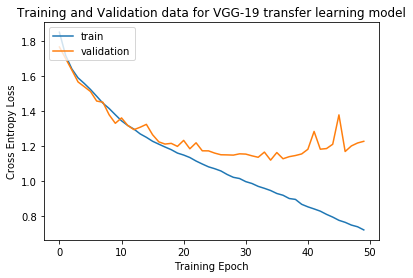

In [60]:
# CODE OBTAINED FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Training and Validation data for VGG-19 transfer learning model')
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [61]:
# get index of predicted facial expression for test set images
expression_predictions_transf = [np.argmax(model_final.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors_transf]

# report test accuracy
test_accuracy = 100*np.sum(np.array(expression_predictions_transf)==np.argmax(test_targets_transf, axis=1))/len(expression_predictions_transf)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 61.0337%


In [62]:
raw_preds = get_model_predictions(model_final, test_tensors_transf)

In [66]:
num_samples = np.array(raw_preds).shape[0]

raw_preds_np = np.array(raw_preds,dtype='float32').reshape(num_samples,7)

print(manual_total_cce(raw_preds_np, test_targets_transf))

1.0769218795470492
